In [7]:
import torch
from prep_data import prep_data
from NNModel import MultiLayerNN
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from prep_data import prep_data

In [8]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [9]:
train_loader, test_loader = prep_data()

In [10]:
torch.manual_seed(42)
model = torch.compile(MultiLayerNN(latent_size=128, num_layers=3), mode="max-autotune").to(device)

In [11]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
for epoch in range(4):
    for data, labels, _ in train_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        loss = criterion(preds, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
    scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.2105
Epoch 2 | Loss: 0.0825
Epoch 3 | Loss: 0.0627
Epoch 4 | Loss: 0.1275


Accuracy: 0.9700


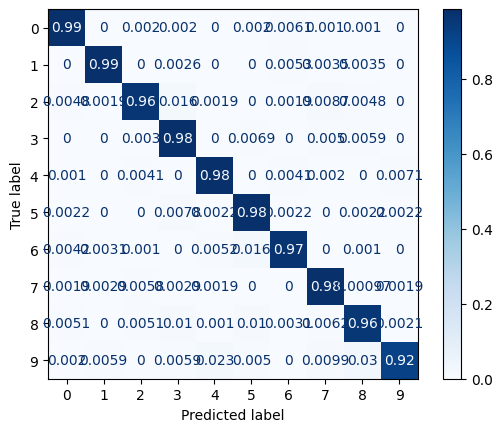

In [13]:
cm = torch.zeros(10, 10)
with torch.no_grad():
    for data, labels, _ in test_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        for i, pred in enumerate(preds):
            cm[labels[i], pred.argmax()] += 1
cm = cm.cpu().numpy()
accuracy = cm.diagonal().sum() / cm.sum()
cm = cm / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
print(f"Accuracy: {accuracy:.4f}")

In [14]:
incorrect_preds = []
with torch.no_grad():
    for loader in [train_loader, test_loader]:
        for data, label, idxs in loader:
            preds = model(data.view(-1, 28*28).to(device))
            labels = torch.argmax(preds, dim=1).cpu()
            incorrect_idxs = labels != label
            incorrect_preds.extend(list(
                zip(
                    idxs[incorrect_idxs].cpu().numpy(), #index
                    labels[incorrect_idxs].cpu().numpy(), #pred label
                    label[incorrect_idxs].cpu().numpy())) #true label
            )


In [15]:
len(incorrect_preds)

1568

In [16]:
with open("./Visualizations/data/incorrect_preds.pkl", "wb") as f:
    pickle.dump(incorrect_preds, f)

In [17]:
torch.save(model.state_dict(), "./Visualizations/data/model.pt")